In [1]:
#MCMC code to fit y = m*x + c to the given (x_data, y_data)
#slope of the line m = tan(theta), where theta is the angle
# made by line with +x axis. The angle 'theta' is used for 
#sampling instead of m, because m varies from zero to infinity. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import corner

In [4]:
%matplotlib inline

In [5]:
#   Generate Data
theta_true = 0.5 #in radian
m_true = 0.5 #np.tan(theta_true) 
c_true = 0.0
#range of x variable
x1 = 0.0; x2 = 10

dx = 1.0
n_data = int((x2 - x1)/dx); print("ndata = ", n_data)

#'data' stores (x,y) data along with the errors on y
data = np.ndarray(shape = (n_data, 3))
#'true_data' stores model (x,y) i.e. y = tan(theta_true)*x + c_true
true_data = np.ndarray(shape = (n_data, 2))
#'inf_data' stores infered (x,y) i.e. y = tan(theta_mean)*x + c_mean
inf_data = np.ndarray(shape = (n_data, 2))

data[:,0] = np.arange(x1, x2, dx)
true_data[:,0] = np.arange(x1, x2, dx)
inf_data[:,0] = np.arange(x1, x2, dx)

ndata =  10


In [6]:
#generative model: our model of how y values in 'data' are generated.
def gen_model(theta, c, x):
    m = np.tan(theta)
    y = m*x + c
    return y

In [7]:
true_data[:,1] = gen_model(theta_true, c_true, data[:,0])
np.savetxt("true_data_1.dat", true_data)

In [8]:
#generate data with uncertainty
#for the purpose of our exercise we want to generate data from the generative model
# with some added uncertainty. This is the data we want to fit our model.
noise_sigma = 0.4
def n_data(x):
    s1 = gen_model(theta_true, c_true, x)
    ns = np.random.normal(s1, noise_sigma, size=None)
    return ns

In [9]:
data[:,1] = n_data(data[:,0])
#use following to have constant errorbar, otherwise comment.
data[:,2].fill(noise_sigma)

In [10]:
#to put some scatter in errorbars uncomment following three lines and comment above line.
#seed = 54321
#np.random.seed(seed)
#data[:,2] = np.random.normal(noise_sigma, 0.1, size = len(data[:,0]))
#data[:,2] = np.abs(true_data[:,1] - data[:,1])
np.savetxt("noisy_data_1.dat", data)

In [11]:
#define the log likelihood. Logarithm of likelihood is used to deal with very small 
#or very large numbers that may occure in the computation of likelihoods.

def log_likelihood(theta, c):
    lnL = -0.5*np.sum(((data[:,1] - gen_model(theta, c, data[:,0]))**2)/data[:,2]**2)
#    print(lnL)
    return lnL

In [12]:
#number of samples
nsample = 10000
#burn in sample
nburn=100

In [13]:
#Choose initial point to start the chain
#theta0 is in radian units
theta0 = 0.030
c0 = 1.5
thetai = theta0
ci = c0

In [14]:
#Parameters of proposal distribution
wtheta = 0.015
wc = 0.15
cov_matrix = np.ndarray(shape = (2,2))
cov_matrix[0,0] = wtheta**2; cov_matrix[0,1] = 0.0; cov_matrix[1,0] = 0.0; cov_matrix[1,1] = wc**2

In [15]:
#Seed for random number generation while sampling
seed1 = 1012345
np.random.seed(seed = seed1)

In [16]:
#array to store total sample
total_sample = np.ndarray(shape = (nsample, 3))
#array to store accepted sample
acptd_sample = np.ndarray(shape = (nsample, 3))

#array to store logarithm of likelihood
lnL = np.ndarray(shape = (nsample, 1))
lnL[0] = log_likelihood(thetai, ci)

In [17]:
#Following loop does the Markov Chain Monte Carlo (MCMC) sampling 
#of the distribution.

n_accept=0
for i in range(1, nsample,1):

#gaussian proposal distribution, zero correlation between two chains.
    thetastar, cstar = np.random.multivariate_normal(mean = np.asarray([thetai,ci]), cov = cov_matrix, size = None)
    temp_arr1 = np.asarray([i, thetastar, cstar])
    total_sample[i,:] = temp_arr1 

    lnL[i] = log_likelihood(thetastar, cstar)

#Metropolic rule
    if lnL[i] > lnL[i-1]:#accept proposed point
        thetai = thetastar
        ci = cstar
        acptd_sample[i,:] = np.asarray([i, thetai, ci])
        n_accept += 1
    else:
        alpha = np.random.random_sample(size = None)
        if lnL[i] - lnL[i-1] > np.log(alpha):#accept proposed point
            ci = cstar
            acptd_sample[i,:] = np.asarray([i, thetai, ci])
            n_accept += 1
        else:#reject proposed point
            #chain stays at the currant point.
            thetai = thetai
            ci = ci
            #Currant (not proposed) point is readded to the accepted sample.
            acptd_sample[i,:] = np.asarray([i, thetai, ci])
            lnL[i] = lnL[i-1]
        #print("acceptance ratio:");print(n_accept/(1.0*i))


In [18]:
chain_m_c = np.zeros_like(acptd_sample)

In [19]:
chain_m_c[:, 0] = acptd_sample[:, 0]
chain_m_c[:, 1] = np.tan(acptd_sample[:, 1])
chain_m_c[:, 2] = acptd_sample[:, 2]

In [20]:
#Compute and print the summary of sampled distribution.
theta_mean = np.mean(acptd_sample[nburn:,1]); c_mean = np.mean(acptd_sample[nburn:,2])
print("theta mean, std dev:"); print(np.mean(acptd_sample[nburn:,1])); 
print(np.sqrt(np.var(acptd_sample[nburn:,1])) )
print("c mean, std dev:"); print(np.mean(acptd_sample[nburn:,2]))
print(np.sqrt(np.var(acptd_sample[nburn:,2])))
#print "covariance:", np.cov(acptd_sample[nburn:,1:3], y = None, rowvar=0, bias=0, ddof=None)

theta mean, std dev:
0.4918285016177151
0.021622824741141126
c mean, std dev:
0.1973821015500345
0.18976390059865175


In [21]:
inf_data[:,1] = gen_model(theta_mean, c_mean, data[:,0])
np.savetxt("inferred_data.dat", inf_data)

np.savetxt("total_proposed_sample.dat", total_sample)
np.savetxt("accepted_sample.dat", acptd_sample)

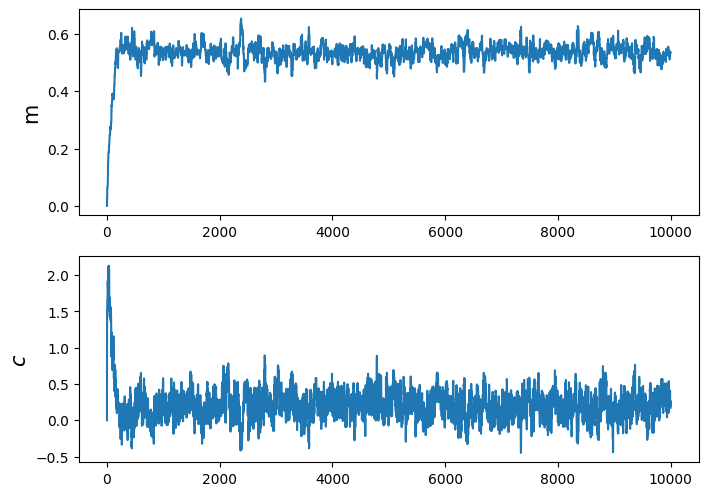

In [22]:
plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plot1 = plt.plot(chain_m_c[:,0], chain_m_c[:,1])
plt.ylabel(r"m", fontsize = 15)
plt.subplot(2,1,2)
plot2 = plt.plot(chain_m_c[:,0], chain_m_c[:,2])
plt.ylabel(r"$c$", fontsize = 15)
#plt.savefig("chain.pdf")
plt.show()

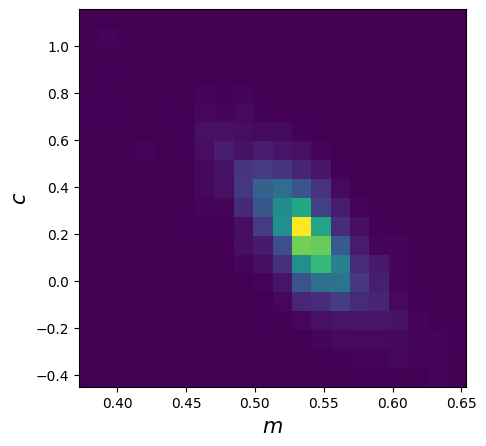

In [23]:
plt.figure(figsize=(5,5), dpi=100)
plot4 = plt.hist2d(chain_m_c[nburn:,1], chain_m_c[nburn:,2], bins=20, density=False)
plt.xlabel(r"$m$", fontsize = 15)
plt.ylabel(r"$c$", fontsize = 15)
#plt.savefig("twoD_histogram.pdf")
plt.show()

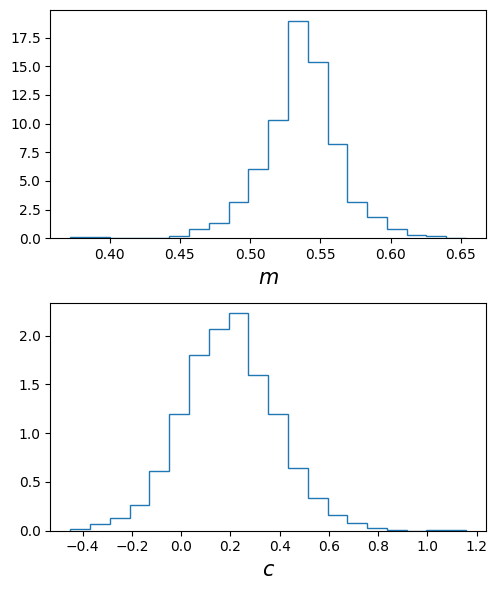

In [24]:
plt.figure(figsize=(5,6), dpi=100)
plt.subplot(2,1,1)
plot5 = plt.hist(chain_m_c[nburn:,1], bins = 20, density=True, histtype='step')
plt.xlabel(r"$m$", fontsize = 15)
plt.subplot(2,1,2)
plot6 = plt.hist(chain_m_c[nburn:,2], bins = 20, density=True, histtype='step')
plt.xlabel(r"$c$", fontsize = 15)
plt.tight_layout()
#plt.savefig("oneD_histogram.pdf")
plt.show()

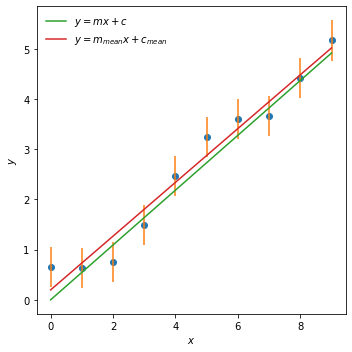

In [25]:
plt.figure(figsize=(5,5))
plt.plot(data[:,0], data[:,1], marker = 'o', linestyle = 'none')
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], linestyle = 'none')
plt.plot(true_data[:,0], true_data[:,1], label = r"$y = mx + c$")
plt.plot(inf_data[:,0], inf_data[:,1], label = r"$y = m_{mean}x + c_{mean}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend(loc='upper left', frameon = False)
plt.tight_layout()
#plt.savefig("data_with_errorbar.pdf")
#plt.show()

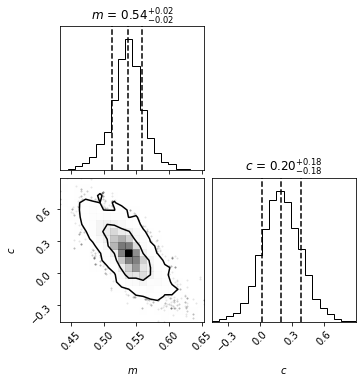

In [26]:
figure = corner.corner(chain_m_c[500:, 1:], labels=[r"$m$", r"$c$"],
                       quantiles=[0.16, 0.5, 0.84], levels=(0.68, 0.95),
                       show_titles=True, title_kwargs={"fontsize": 12})

In [27]:
ur = np.random.uniform(0, 1, 10000)

In [28]:
ur

array([0.10379091, 0.66347365, 0.72529562, ..., 0.00625844, 0.92072641,
       0.20345744])

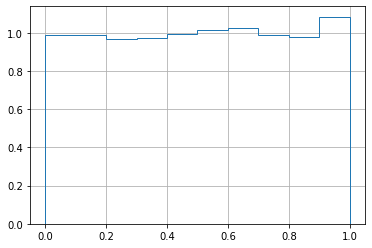

In [29]:
h = plt.hist(ur, histtype='step', density = True)
plt.grid()